In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import asyncio
import urllib.request

#Check if GPU is fried yet
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

In [3]:
X.shape

(10000, 50, 50, 1)

In [4]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

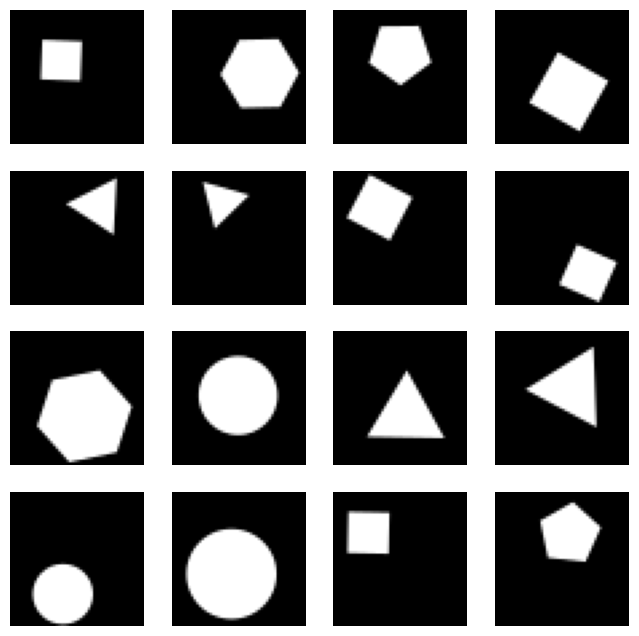

In [5]:
#Original data visualisation

data_generator = ImageDataGenerator()
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

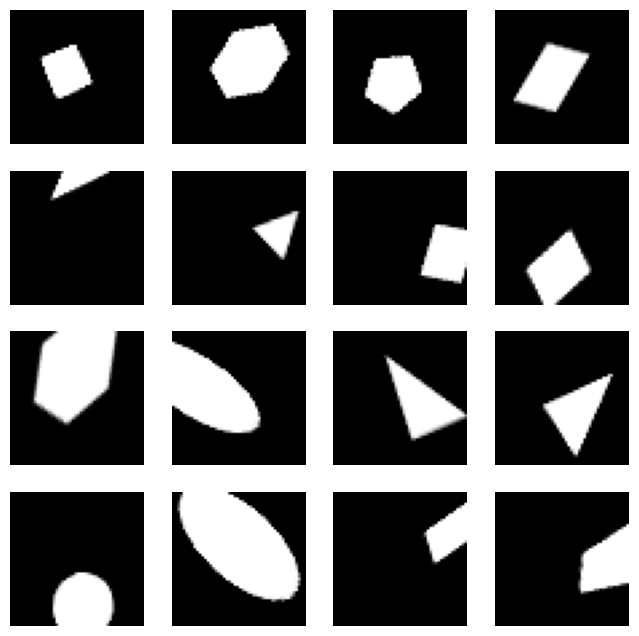

In [6]:
#Data augmentation visualisation

data_generator = ImageDataGenerator(
    rotation_range = 90,
    zoom_range = 0.2,
    shear_range = 45,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    channel_shift_range = 0.9,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

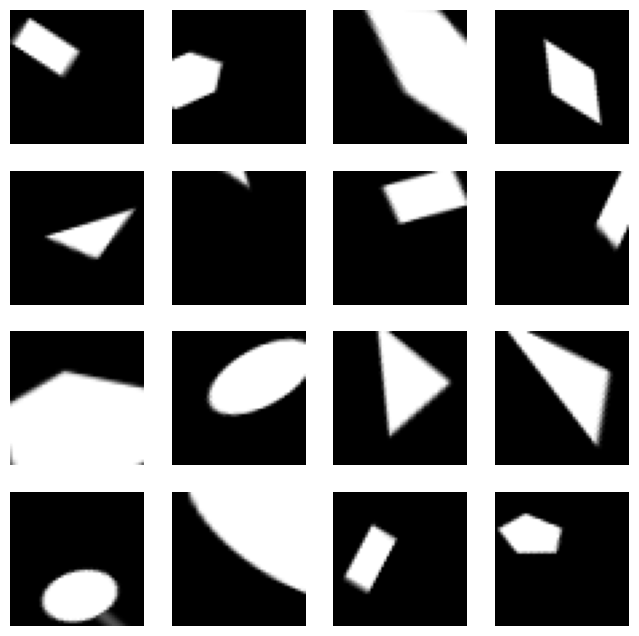

In [7]:
#Train for the worst

data_generator = ImageDataGenerator(
    rotation_range = 180,
    zoom_range = 0.5,
    shear_range = 70,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.25,
    width_shift_range = 0.25,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

In [8]:
#99.48% on advanced model, 17.6MB

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '17.6MB_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856 

80/80 [==============================] - 4s 51ms/step - loss: 0.5709 - accuracy: 0.7961 - val_loss: 0.4743 - val_accuracy: 0.8280
Epoch 93/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5762 - accuracy: 0.7979 - val_loss: 0.4693 - val_accuracy: 0.8365
Epoch 94/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5602 - accuracy: 0.8006 - val_loss: 0.5055 - val_accuracy: 0.8205
Epoch 95/200
80/80 [==============================] - 4s 53ms/step - loss: 0.5587 - accuracy: 0.8053 - val_loss: 0.4453 - val_accuracy: 0.8385
Epoch 96/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5582 - accuracy: 0.7999 - val_loss: 0.4836 - val_accuracy: 0.8200
Epoch 97/200
80/80 [==============================] - 4s 48ms/step - loss: 0.5570 - accuracy: 0.7990 - val_loss: 0.4468 - val_accuracy: 0.8355
Epoch 98/200
80/80 [==============================] - 4s 52ms/step - loss: 0.5658 - accuracy: 0.8029 - val_loss: 0.4118 - val_accuracy: 0.8560
Epoch 99/200

80/80 [==============================] - 4s 49ms/step - loss: 0.5042 - accuracy: 0.8200 - val_loss: 0.3897 - val_accuracy: 0.8640
Epoch 150/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5083 - accuracy: 0.8279 - val_loss: 0.4065 - val_accuracy: 0.8505
Epoch 151/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5172 - accuracy: 0.8185 - val_loss: 0.4050 - val_accuracy: 0.8575
Epoch 152/200
80/80 [==============================] - 4s 51ms/step - loss: 0.5084 - accuracy: 0.8203 - val_loss: 0.3903 - val_accuracy: 0.8595
Epoch 153/200
80/80 [==============================] - 4s 50ms/step - loss: 0.5070 - accuracy: 0.8225 - val_loss: 0.4138 - val_accuracy: 0.8485
Epoch 154/200
80/80 [==============================] - 4s 56ms/step - loss: 0.4849 - accuracy: 0.8343 - val_loss: 0.4126 - val_accuracy: 0.8485
Epoch 155/200
80/80 [==============================] - 4s 49ms/step - loss: 0.4965 - accuracy: 0.8224 - val_loss: 0.3856 - val_accuracy: 0.8625
Epoch 

<AxesSubplot: >

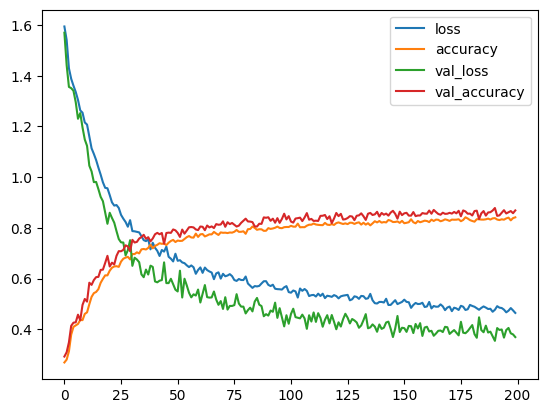

In [9]:
#Funny squiggles

pd.DataFrame(hist.history).plot()

In [10]:
#Fail, bad accuracy and HUGE model

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(1024, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       7385

Epoch 28/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7922 - accuracy: 0.6901 - val_loss: 0.8677 - val_accuracy: 0.6475
Epoch 29/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7753 - accuracy: 0.6994 - val_loss: 0.7809 - val_accuracy: 0.7065
Epoch 30/200
80/80 [==============================] - 4s 50ms/step - loss: 0.7586 - accuracy: 0.7049 - val_loss: 0.7391 - val_accuracy: 0.7070
Epoch 31/200
80/80 [==============================] - 4s 50ms/step - loss: 0.7333 - accuracy: 0.7224 - val_loss: 0.6821 - val_accuracy: 0.7325
Epoch 32/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7393 - accuracy: 0.7150 - val_loss: 0.6821 - val_accuracy: 0.7260
Epoch 33/200
80/80 [==============================] - 4s 51ms/step - loss: 0.7382 - accuracy: 0.7261 - val_loss: 0.8306 - val_accuracy: 0.6765
Epoch 34/200
80/80 [==============================] - 4s 50ms/step - loss: 0.7144 - accuracy: 0.7280 - val_loss: 0.6904 - val_accuracy: 0.7365

80/80 [==============================] - 4s 51ms/step - loss: 0.4527 - accuracy: 0.8475 - val_loss: 0.4635 - val_accuracy: 0.8425
Epoch 143/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4438 - accuracy: 0.8548 - val_loss: 0.5328 - val_accuracy: 0.8440
Epoch 144/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4461 - accuracy: 0.8455 - val_loss: 0.5065 - val_accuracy: 0.8565
Epoch 145/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4510 - accuracy: 0.8489 - val_loss: 0.4451 - val_accuracy: 0.8755
Epoch 146/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4455 - accuracy: 0.8494 - val_loss: 0.4509 - val_accuracy: 0.8570
Epoch 147/200
80/80 [==============================] - 4s 51ms/step - loss: 0.4548 - accuracy: 0.8485 - val_loss: 0.5033 - val_accuracy: 0.8705
Epoch 148/200
80/80 [==============================] - 4s 52ms/step - loss: 0.4423 - accuracy: 0.8519 - val_loss: 0.4681 - val_accuracy: 0.8680
Epoch 

Epoch 199/200
80/80 [==============================] - 4s 50ms/step - loss: 0.4226 - accuracy: 0.8645 - val_loss: 0.4202 - val_accuracy: 0.8855
Epoch 200/200
80/80 [==============================] - 4s 50ms/step - loss: 0.4129 - accuracy: 0.8691 - val_loss: 0.4269 - val_accuracy: 0.8785


<AxesSubplot: >

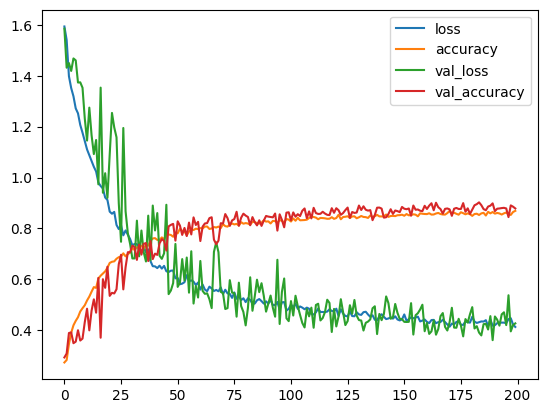

In [11]:
#More funny squiggles

pd.DataFrame(hist.history).plot()

In [12]:
#Model that got 100% on advanced, 23MB

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(5, 5), padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(4, 4), padding = 'same')(out);
out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
for i in range(3):
    out = keras.layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')(out);
    out = keras.layers.Activation("relu")(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(1000, activation = 'relu')(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '23MB_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 200, callbacks = [checkpoint]);

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        832       
                                                                 
 activation (Activation)     (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 25, 25, 64)        0         
                                                           

80/80 [==============================] - 4s 52ms/step - loss: 0.3031 - accuracy: 0.8993 - val_loss: 0.3136 - val_accuracy: 0.8990
Epoch 87/200
80/80 [==============================] - 4s 51ms/step - loss: 0.3001 - accuracy: 0.8995 - val_loss: 0.2836 - val_accuracy: 0.8985
Epoch 88/200
80/80 [==============================] - 4s 51ms/step - loss: 0.3026 - accuracy: 0.9010 - val_loss: 0.2802 - val_accuracy: 0.9015
Epoch 89/200
80/80 [==============================] - 4s 51ms/step - loss: 0.2982 - accuracy: 0.9020 - val_loss: 0.2679 - val_accuracy: 0.9090
Epoch 90/200
80/80 [==============================] - 4s 50ms/step - loss: 0.2900 - accuracy: 0.9028 - val_loss: 0.2653 - val_accuracy: 0.9055
Epoch 91/200
80/80 [==============================] - 4s 51ms/step - loss: 0.2951 - accuracy: 0.9051 - val_loss: 0.2887 - val_accuracy: 0.8945
Epoch 92/200
80/80 [==============================] - 4s 52ms/step - loss: 0.2955 - accuracy: 0.9038 - val_loss: 0.2757 - val_accuracy: 0.9075
Epoch 93/200

80/80 [==============================] - 4s 51ms/step - loss: 0.2677 - accuracy: 0.9133 - val_loss: 0.2175 - val_accuracy: 0.9315
Epoch 144/200
80/80 [==============================] - 4s 49ms/step - loss: 0.2764 - accuracy: 0.9120 - val_loss: 0.2481 - val_accuracy: 0.9195
Epoch 145/200
80/80 [==============================] - 4s 49ms/step - loss: 0.2639 - accuracy: 0.9156 - val_loss: 0.2703 - val_accuracy: 0.9020
Epoch 146/200
80/80 [==============================] - 4s 50ms/step - loss: 0.2844 - accuracy: 0.9056 - val_loss: 0.2535 - val_accuracy: 0.9145
Epoch 147/200
80/80 [==============================] - 4s 51ms/step - loss: 0.2787 - accuracy: 0.9129 - val_loss: 0.2462 - val_accuracy: 0.9160
Epoch 148/200
80/80 [==============================] - 4s 49ms/step - loss: 0.2747 - accuracy: 0.9126 - val_loss: 0.2559 - val_accuracy: 0.9120
Epoch 149/200
80/80 [==============================] - 4s 50ms/step - loss: 0.2764 - accuracy: 0.9108 - val_loss: 0.2357 - val_accuracy: 0.9225
Epoch 

Epoch 200/200
80/80 [==============================] - 4s 49ms/step - loss: 0.2619 - accuracy: 0.9154 - val_loss: 0.2387 - val_accuracy: 0.9205


<AxesSubplot: >

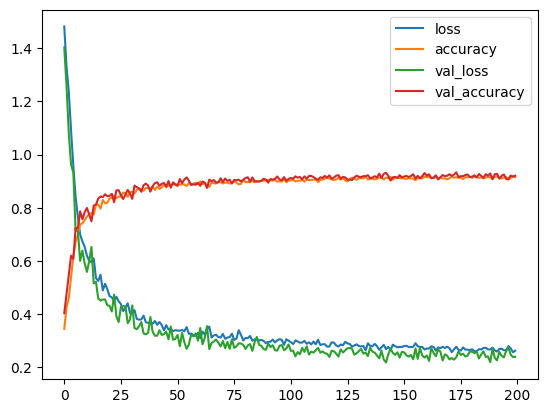

In [13]:
#Even more funny squiggles

pd.DataFrame(hist.history).plot()

In [14]:
#Load the winner, continue training and save all epochs for... reasons

model = tf.keras.models.load_model('23MB_model.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '23MB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

Epoch 1/20
80/80 [==============================] - 5s 54ms/step - loss: 0.2736 - accuracy: 0.9099 - val_loss: 0.2195 - val_accuracy: 0.9325
Epoch 2/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2745 - accuracy: 0.9106 - val_loss: 0.2565 - val_accuracy: 0.9085
Epoch 3/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2743 - accuracy: 0.9110 - val_loss: 0.2517 - val_accuracy: 0.9215
Epoch 4/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2794 - accuracy: 0.9084 - val_loss: 0.2399 - val_accuracy: 0.9215
Epoch 5/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2733 - accuracy: 0.9125 - val_loss: 0.2483 - val_accuracy: 0.9220
Epoch 6/20
80/80 [==============================] - 4s 54ms/step - loss: 0.2746 - accuracy: 0.9093 - val_loss: 0.2469 - val_accuracy: 0.9190
Epoch 7/20
80/80 [==============================] - 4s 50ms/step - loss: 0.2847 - accuracy: 0.9066 - val_loss: 0.2607 - val_accuracy: 0.9080
Epoch 8/20
80

In [15]:
#Here's a little lesson in trickery

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def brute_force(x, folder_name):
    url = 'https://us-central1-aiprimer.cloudfunctions.net/flatland?model_link=https://github.com/DDomjosa/flatland/blob/main/' + folder_name + '/' + str(x) + 'model.h5?raw=true';
    uf = urllib.request.urlopen(url)
    html = uf.read()
    print('Epoch = ' + str(x) + ':\n\n' + html.decode("utf-8") + '\n')

In [16]:
for i in range(1, 21):
    brute_force(i, '23MB_epochs')

Epoch = 19:

Train set accuracy 98.52%
Test set (simple) accuracy 100.00%
Test set (adv.) accuracy 100.00%

Epoch = 18:

Train set accuracy 98.52%
Test set (simple) accuracy 100.00%
Test set (adv.) accuracy 100.00%

Epoch = 15:

Train set accuracy 98.52%
Test set (simple) accuracy 100.00%
Test set (adv.) accuracy 100.00%

Epoch = 20:

Train set accuracy 98.51%
Test set (simple) accuracy 100.00%
Test set (adv.) accuracy 99.98%

Epoch = 17:

Train set accuracy 98.52%
Test set (simple) accuracy 100.00%
Test set (adv.) accuracy 100.00%

Epoch = 8:

Train set accuracy 98.52%
Test set (simple) accuracy 100.00%
Test set (adv.) accuracy 100.00%

Epoch = 14:

Train set accuracy 98.52%
Test set (simple) accuracy 99.99%
Test set (adv.) accuracy 99.93%

Epoch = 16:

Train set accuracy 98.52%
Test set (simple) accuracy 99.99%
Test set (adv.) accuracy 99.99%

Epoch = 9:

Train set accuracy 98.52%
Test set (simple) accuracy 99.99%
Test set (adv.) accuracy 99.97%

Epoch = 13:

Train set accuracy 98.52

In [17]:
#100% on advanced, 673KB
#Needs A LOT of training to reach 100%

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(5, 5), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.3)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '673KB_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 2500, callbacks = [checkpoint]);

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        6416      
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 16)        6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 16)        2320      
                                                             

80/80 [==============================] - 5s 59ms/step - loss: 0.7315 - accuracy: 0.7258 - val_loss: 0.7215 - val_accuracy: 0.7285
Epoch 40/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.7402 - accuracy: 0.7231 - val_loss: 0.6714 - val_accuracy: 0.7620
Epoch 41/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.7353 - accuracy: 0.7299 - val_loss: 0.7112 - val_accuracy: 0.7470
Epoch 42/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.7304 - accuracy: 0.7230 - val_loss: 0.6567 - val_accuracy: 0.7685
Epoch 43/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.7175 - accuracy: 0.7438 - val_loss: 0.6697 - val_accuracy: 0.7555
Epoch 44/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.7259 - accuracy: 0.7328 - val_loss: 0.6550 - val_accuracy: 0.7610
Epoch 45/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.7274 - accuracy: 0.7364 - val_loss: 0.6935 - val_accuracy: 0.7445
Epoch 

Epoch 96/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.5877 - accuracy: 0.7994 - val_loss: 0.5457 - val_accuracy: 0.8075
Epoch 97/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5811 - accuracy: 0.7991 - val_loss: 0.5562 - val_accuracy: 0.7720
Epoch 98/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5604 - accuracy: 0.8025 - val_loss: 0.5205 - val_accuracy: 0.8115
Epoch 99/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.6070 - accuracy: 0.7854 - val_loss: 0.5503 - val_accuracy: 0.7925
Epoch 100/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.5659 - accuracy: 0.7980 - val_loss: 0.5277 - val_accuracy: 0.8155
Epoch 101/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5972 - accuracy: 0.7855 - val_loss: 0.5175 - val_accuracy: 0.8210
Epoch 102/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5796 - accuracy: 0.7940 - val_loss: 0.6389 - val_accura

80/80 [==============================] - 4s 52ms/step - loss: 0.4969 - accuracy: 0.8233 - val_loss: 0.4603 - val_accuracy: 0.8370
Epoch 153/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.5218 - accuracy: 0.8201 - val_loss: 0.5049 - val_accuracy: 0.8290
Epoch 154/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5213 - accuracy: 0.8181 - val_loss: 0.4631 - val_accuracy: 0.8435
Epoch 155/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5049 - accuracy: 0.8306 - val_loss: 0.5001 - val_accuracy: 0.8280
Epoch 156/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.5196 - accuracy: 0.8245 - val_loss: 0.4629 - val_accuracy: 0.8450
Epoch 157/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.5054 - accuracy: 0.8245 - val_loss: 0.4708 - val_accuracy: 0.8310
Epoch 158/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.5208 - accuracy: 0.8238 - val_loss: 0.4863 - val_accuracy: 0.8330


80/80 [==============================] - 4s 52ms/step - loss: 0.4595 - accuracy: 0.8478 - val_loss: 0.4699 - val_accuracy: 0.8355
Epoch 209/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4645 - accuracy: 0.8413 - val_loss: 0.4570 - val_accuracy: 0.8245
Epoch 210/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4907 - accuracy: 0.8311 - val_loss: 0.4038 - val_accuracy: 0.8730
Epoch 211/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.4709 - accuracy: 0.8383 - val_loss: 0.4328 - val_accuracy: 0.8455
Epoch 212/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4656 - accuracy: 0.8379 - val_loss: 0.4126 - val_accuracy: 0.8535
Epoch 213/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.4459 - accuracy: 0.8508 - val_loss: 0.4431 - val_accuracy: 0.8425
Epoch 214/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.4731 - accuracy: 0.8413 - val_loss: 0.4393 - val_accuracy: 0.8490


80/80 [==============================] - 4s 53ms/step - loss: 0.4529 - accuracy: 0.8460 - val_loss: 0.3628 - val_accuracy: 0.8830
Epoch 265/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.4236 - accuracy: 0.8555 - val_loss: 0.4306 - val_accuracy: 0.8485
Epoch 266/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4343 - accuracy: 0.8573 - val_loss: 0.3865 - val_accuracy: 0.8620
Epoch 267/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4384 - accuracy: 0.8584 - val_loss: 0.3766 - val_accuracy: 0.8760
Epoch 268/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4167 - accuracy: 0.8653 - val_loss: 0.3832 - val_accuracy: 0.8745
Epoch 269/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.4552 - accuracy: 0.8479 - val_loss: 0.4006 - val_accuracy: 0.8595
Epoch 270/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4278 - accuracy: 0.8578 - val_loss: 0.3842 - val_accuracy: 0.8750


80/80 [==============================] - 4s 53ms/step - loss: 0.4023 - accuracy: 0.8663 - val_loss: 0.3669 - val_accuracy: 0.8750
Epoch 321/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.4004 - accuracy: 0.8706 - val_loss: 0.3325 - val_accuracy: 0.8930
Epoch 322/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4042 - accuracy: 0.8710 - val_loss: 0.3674 - val_accuracy: 0.8755
Epoch 323/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4016 - accuracy: 0.8634 - val_loss: 0.3585 - val_accuracy: 0.8870
Epoch 324/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3905 - accuracy: 0.8680 - val_loss: 0.3615 - val_accuracy: 0.8820
Epoch 325/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4238 - accuracy: 0.8633 - val_loss: 0.3482 - val_accuracy: 0.8810
Epoch 326/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.4050 - accuracy: 0.8670 - val_loss: 0.3522 - val_accuracy: 0.8830


80/80 [==============================] - 4s 52ms/step - loss: 0.4003 - accuracy: 0.8684 - val_loss: 0.3434 - val_accuracy: 0.8860
Epoch 377/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3952 - accuracy: 0.8698 - val_loss: 0.3332 - val_accuracy: 0.8890
Epoch 378/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3616 - accuracy: 0.8814 - val_loss: 0.3309 - val_accuracy: 0.8895
Epoch 379/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3950 - accuracy: 0.8674 - val_loss: 0.3892 - val_accuracy: 0.8620
Epoch 380/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3774 - accuracy: 0.8785 - val_loss: 0.3305 - val_accuracy: 0.8885
Epoch 381/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3892 - accuracy: 0.8730 - val_loss: 0.3519 - val_accuracy: 0.8910
Epoch 382/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3894 - accuracy: 0.8749 - val_loss: 0.4034 - val_accuracy: 0.8615


80/80 [==============================] - 4s 53ms/step - loss: 0.3615 - accuracy: 0.8861 - val_loss: 0.3556 - val_accuracy: 0.8820
Epoch 433/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3672 - accuracy: 0.8806 - val_loss: 0.4115 - val_accuracy: 0.8555
Epoch 434/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3825 - accuracy: 0.8770 - val_loss: 0.3427 - val_accuracy: 0.8840
Epoch 435/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3781 - accuracy: 0.8795 - val_loss: 0.3563 - val_accuracy: 0.8795
Epoch 436/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3544 - accuracy: 0.8884 - val_loss: 0.3171 - val_accuracy: 0.8960
Epoch 437/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3755 - accuracy: 0.8798 - val_loss: 0.3776 - val_accuracy: 0.8690
Epoch 438/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3787 - accuracy: 0.8760 - val_loss: 0.3240 - val_accuracy: 0.8910


80/80 [==============================] - 4s 52ms/step - loss: 0.3724 - accuracy: 0.8811 - val_loss: 0.3296 - val_accuracy: 0.8885
Epoch 489/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3716 - accuracy: 0.8784 - val_loss: 0.3249 - val_accuracy: 0.8940
Epoch 490/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3536 - accuracy: 0.8910 - val_loss: 0.3175 - val_accuracy: 0.8985
Epoch 491/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3563 - accuracy: 0.8814 - val_loss: 0.3194 - val_accuracy: 0.8950
Epoch 492/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3619 - accuracy: 0.8773 - val_loss: 0.3254 - val_accuracy: 0.8925
Epoch 493/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3646 - accuracy: 0.8815 - val_loss: 0.3084 - val_accuracy: 0.8965
Epoch 494/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3537 - accuracy: 0.8871 - val_loss: 0.3279 - val_accuracy: 0.8910


80/80 [==============================] - 4s 52ms/step - loss: 0.3510 - accuracy: 0.8853 - val_loss: 0.3100 - val_accuracy: 0.8985
Epoch 545/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3559 - accuracy: 0.8821 - val_loss: 0.3098 - val_accuracy: 0.8950
Epoch 546/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3438 - accuracy: 0.8884 - val_loss: 0.3182 - val_accuracy: 0.8925
Epoch 547/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3514 - accuracy: 0.8881 - val_loss: 0.3205 - val_accuracy: 0.8915
Epoch 548/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3424 - accuracy: 0.8891 - val_loss: 0.3243 - val_accuracy: 0.8860
Epoch 549/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3533 - accuracy: 0.8855 - val_loss: 0.3145 - val_accuracy: 0.9015
Epoch 550/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3687 - accuracy: 0.8811 - val_loss: 0.2947 - val_accuracy: 0.9010


80/80 [==============================] - 4s 52ms/step - loss: 0.3462 - accuracy: 0.8865 - val_loss: 0.2789 - val_accuracy: 0.9060
Epoch 601/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3493 - accuracy: 0.8900 - val_loss: 0.3059 - val_accuracy: 0.9025
Epoch 602/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3484 - accuracy: 0.8896 - val_loss: 0.3191 - val_accuracy: 0.8935
Epoch 603/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3452 - accuracy: 0.8933 - val_loss: 0.3200 - val_accuracy: 0.9005
Epoch 604/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3448 - accuracy: 0.8889 - val_loss: 0.3113 - val_accuracy: 0.9050
Epoch 605/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3534 - accuracy: 0.8891 - val_loss: 0.3148 - val_accuracy: 0.9035
Epoch 606/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3320 - accuracy: 0.8943 - val_loss: 0.3118 - val_accuracy: 0.8935


80/80 [==============================] - 4s 52ms/step - loss: 0.3296 - accuracy: 0.8979 - val_loss: 0.2872 - val_accuracy: 0.9090
Epoch 657/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3393 - accuracy: 0.8941 - val_loss: 0.2652 - val_accuracy: 0.9140
Epoch 658/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3376 - accuracy: 0.8939 - val_loss: 0.3044 - val_accuracy: 0.9015
Epoch 659/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3410 - accuracy: 0.8949 - val_loss: 0.3160 - val_accuracy: 0.8900
Epoch 660/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3243 - accuracy: 0.8983 - val_loss: 0.2960 - val_accuracy: 0.9040
Epoch 661/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3333 - accuracy: 0.8916 - val_loss: 0.3165 - val_accuracy: 0.8950
Epoch 662/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3340 - accuracy: 0.8873 - val_loss: 0.3264 - val_accuracy: 0.8945


80/80 [==============================] - 4s 52ms/step - loss: 0.3258 - accuracy: 0.8969 - val_loss: 0.2846 - val_accuracy: 0.9080
Epoch 713/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3188 - accuracy: 0.9016 - val_loss: 0.2989 - val_accuracy: 0.9020
Epoch 714/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3279 - accuracy: 0.8936 - val_loss: 0.3007 - val_accuracy: 0.8960
Epoch 715/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3156 - accuracy: 0.9003 - val_loss: 0.2835 - val_accuracy: 0.8995
Epoch 716/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3267 - accuracy: 0.8951 - val_loss: 0.2693 - val_accuracy: 0.9210
Epoch 717/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3376 - accuracy: 0.8871 - val_loss: 0.3263 - val_accuracy: 0.8885
Epoch 718/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3298 - accuracy: 0.8944 - val_loss: 0.2793 - val_accuracy: 0.9095


80/80 [==============================] - 4s 53ms/step - loss: 0.3314 - accuracy: 0.8915 - val_loss: 0.2954 - val_accuracy: 0.9035
Epoch 769/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3195 - accuracy: 0.9024 - val_loss: 0.2745 - val_accuracy: 0.9100
Epoch 770/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3180 - accuracy: 0.9004 - val_loss: 0.2971 - val_accuracy: 0.9040
Epoch 771/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3240 - accuracy: 0.8948 - val_loss: 0.2889 - val_accuracy: 0.9075
Epoch 772/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3223 - accuracy: 0.8994 - val_loss: 0.2864 - val_accuracy: 0.9000
Epoch 773/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3201 - accuracy: 0.8926 - val_loss: 0.3125 - val_accuracy: 0.8995
Epoch 774/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3257 - accuracy: 0.8953 - val_loss: 0.2780 - val_accuracy: 0.9080


80/80 [==============================] - 4s 53ms/step - loss: 0.3293 - accuracy: 0.8984 - val_loss: 0.2909 - val_accuracy: 0.9155
Epoch 825/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3220 - accuracy: 0.8945 - val_loss: 0.3009 - val_accuracy: 0.8950
Epoch 826/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3145 - accuracy: 0.8995 - val_loss: 0.2798 - val_accuracy: 0.9095
Epoch 827/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3267 - accuracy: 0.8934 - val_loss: 0.2776 - val_accuracy: 0.9085
Epoch 828/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3213 - accuracy: 0.8959 - val_loss: 0.3030 - val_accuracy: 0.9010
Epoch 829/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3176 - accuracy: 0.8979 - val_loss: 0.2770 - val_accuracy: 0.9125
Epoch 830/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3159 - accuracy: 0.9001 - val_loss: 0.2662 - val_accuracy: 0.9160


80/80 [==============================] - 4s 52ms/step - loss: 0.3081 - accuracy: 0.9013 - val_loss: 0.2836 - val_accuracy: 0.9125
Epoch 881/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.3073 - accuracy: 0.9038 - val_loss: 0.2969 - val_accuracy: 0.9040
Epoch 882/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.3123 - accuracy: 0.9016 - val_loss: 0.2915 - val_accuracy: 0.9090
Epoch 883/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.3119 - accuracy: 0.9028 - val_loss: 0.2811 - val_accuracy: 0.9160
Epoch 884/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.3275 - accuracy: 0.8961 - val_loss: 0.2831 - val_accuracy: 0.9095
Epoch 885/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3206 - accuracy: 0.8981 - val_loss: 0.2767 - val_accuracy: 0.9075
Epoch 886/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3120 - accuracy: 0.9016 - val_loss: 0.2808 - val_accuracy: 0.9130


80/80 [==============================] - 4s 52ms/step - loss: 0.3183 - accuracy: 0.8995 - val_loss: 0.2920 - val_accuracy: 0.9080
Epoch 937/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.3031 - accuracy: 0.9045 - val_loss: 0.3128 - val_accuracy: 0.8945
Epoch 938/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.3318 - accuracy: 0.8945 - val_loss: 0.2793 - val_accuracy: 0.9085
Epoch 939/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3080 - accuracy: 0.9050 - val_loss: 0.2878 - val_accuracy: 0.9100
Epoch 940/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.3033 - accuracy: 0.9056 - val_loss: 0.2840 - val_accuracy: 0.9150
Epoch 941/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2902 - accuracy: 0.9091 - val_loss: 0.2850 - val_accuracy: 0.9110
Epoch 942/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3187 - accuracy: 0.8943 - val_loss: 0.2724 - val_accuracy: 0.9150


80/80 [==============================] - 4s 52ms/step - loss: 0.3174 - accuracy: 0.9006 - val_loss: 0.3034 - val_accuracy: 0.8985
Epoch 993/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3083 - accuracy: 0.8999 - val_loss: 0.2694 - val_accuracy: 0.9140
Epoch 994/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3096 - accuracy: 0.9041 - val_loss: 0.2867 - val_accuracy: 0.9105
Epoch 995/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.3020 - accuracy: 0.9068 - val_loss: 0.2785 - val_accuracy: 0.9130
Epoch 996/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2997 - accuracy: 0.9050 - val_loss: 0.2682 - val_accuracy: 0.9110
Epoch 997/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3148 - accuracy: 0.8985 - val_loss: 0.2756 - val_accuracy: 0.9135
Epoch 998/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3145 - accuracy: 0.9004 - val_loss: 0.2736 - val_accuracy: 0.9060


80/80 [==============================] - 4s 49ms/step - loss: 0.3078 - accuracy: 0.9056 - val_loss: 0.2561 - val_accuracy: 0.9215
Epoch 1049/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3066 - accuracy: 0.9030 - val_loss: 0.2444 - val_accuracy: 0.9260
Epoch 1050/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.3049 - accuracy: 0.9014 - val_loss: 0.2774 - val_accuracy: 0.9140
Epoch 1051/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3068 - accuracy: 0.9024 - val_loss: 0.2653 - val_accuracy: 0.9180
Epoch 1052/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3015 - accuracy: 0.9023 - val_loss: 0.2518 - val_accuracy: 0.9260
Epoch 1053/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3056 - accuracy: 0.9055 - val_loss: 0.2702 - val_accuracy: 0.9235
Epoch 1054/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3108 - accuracy: 0.9000 - val_loss: 0.2828 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.3129 - accuracy: 0.9048 - val_loss: 0.2604 - val_accuracy: 0.9155
Epoch 1105/2500
80/80 [==============================] - 5s 58ms/step - loss: 0.3001 - accuracy: 0.9066 - val_loss: 0.2726 - val_accuracy: 0.9140
Epoch 1106/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2941 - accuracy: 0.9066 - val_loss: 0.2740 - val_accuracy: 0.9100
Epoch 1107/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.3039 - accuracy: 0.9034 - val_loss: 0.2588 - val_accuracy: 0.9165
Epoch 1108/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2882 - accuracy: 0.9114 - val_loss: 0.2732 - val_accuracy: 0.9150
Epoch 1109/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3007 - accuracy: 0.9055 - val_loss: 0.2524 - val_accuracy: 0.9235
Epoch 1110/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2957 - accuracy: 0.9076 - val_loss: 0.2690 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.2860 - accuracy: 0.9114 - val_loss: 0.2766 - val_accuracy: 0.9090
Epoch 1161/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3095 - accuracy: 0.9014 - val_loss: 0.2691 - val_accuracy: 0.9115
Epoch 1162/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2842 - accuracy: 0.9128 - val_loss: 0.2819 - val_accuracy: 0.9130
Epoch 1163/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.3029 - accuracy: 0.9021 - val_loss: 0.2957 - val_accuracy: 0.9025
Epoch 1164/2500
80/80 [==============================] - 4s 47ms/step - loss: 0.3092 - accuracy: 0.9009 - val_loss: 0.2528 - val_accuracy: 0.9270
Epoch 1165/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.3019 - accuracy: 0.9035 - val_loss: 0.2852 - val_accuracy: 0.9075
Epoch 1166/2500
80/80 [==============================] - 4s 47ms/step - loss: 0.2950 - accuracy: 0.9080 - val_loss: 0.2720 - val_accuracy: 0

80/80 [==============================] - 4s 50ms/step - loss: 0.2883 - accuracy: 0.9035 - val_loss: 0.2769 - val_accuracy: 0.9125
Epoch 1217/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2991 - accuracy: 0.9091 - val_loss: 0.2765 - val_accuracy: 0.9080
Epoch 1218/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2984 - accuracy: 0.9090 - val_loss: 0.2565 - val_accuracy: 0.9155
Epoch 1219/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2989 - accuracy: 0.9026 - val_loss: 0.2482 - val_accuracy: 0.9325
Epoch 1220/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2959 - accuracy: 0.9064 - val_loss: 0.2636 - val_accuracy: 0.9160
Epoch 1221/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2928 - accuracy: 0.9116 - val_loss: 0.2686 - val_accuracy: 0.9125
Epoch 1222/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.3028 - accuracy: 0.9045 - val_loss: 0.2800 - val_accuracy: 0

80/80 [==============================] - 4s 55ms/step - loss: 0.3016 - accuracy: 0.9068 - val_loss: 0.2378 - val_accuracy: 0.9270
Epoch 1273/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2910 - accuracy: 0.9090 - val_loss: 0.2464 - val_accuracy: 0.9240
Epoch 1274/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2838 - accuracy: 0.9134 - val_loss: 0.2544 - val_accuracy: 0.9255
Epoch 1275/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3027 - accuracy: 0.9061 - val_loss: 0.2678 - val_accuracy: 0.9170
Epoch 1276/2500
80/80 [==============================] - 4s 55ms/step - loss: 0.2985 - accuracy: 0.9078 - val_loss: 0.2687 - val_accuracy: 0.9070
Epoch 1277/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2941 - accuracy: 0.9120 - val_loss: 0.2451 - val_accuracy: 0.9180
Epoch 1278/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2865 - accuracy: 0.9109 - val_loss: 0.2611 - val_accuracy: 0

80/80 [==============================] - 4s 53ms/step - loss: 0.2914 - accuracy: 0.9070 - val_loss: 0.2603 - val_accuracy: 0.9155
Epoch 1329/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2897 - accuracy: 0.9080 - val_loss: 0.2610 - val_accuracy: 0.9180
Epoch 1330/2500
80/80 [==============================] - 5s 56ms/step - loss: 0.2847 - accuracy: 0.9096 - val_loss: 0.2726 - val_accuracy: 0.9065
Epoch 1331/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2851 - accuracy: 0.9135 - val_loss: 0.2470 - val_accuracy: 0.9295
Epoch 1332/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2819 - accuracy: 0.9141 - val_loss: 0.2441 - val_accuracy: 0.9240
Epoch 1333/2500
80/80 [==============================] - 4s 56ms/step - loss: 0.2833 - accuracy: 0.9106 - val_loss: 0.2644 - val_accuracy: 0.9205
Epoch 1334/2500
80/80 [==============================] - 4s 55ms/step - loss: 0.2949 - accuracy: 0.9053 - val_loss: 0.2589 - val_accuracy: 0

80/80 [==============================] - 4s 55ms/step - loss: 0.2931 - accuracy: 0.9048 - val_loss: 0.2639 - val_accuracy: 0.9190
Epoch 1385/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2888 - accuracy: 0.9093 - val_loss: 0.2680 - val_accuracy: 0.9095
Epoch 1386/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2929 - accuracy: 0.9074 - val_loss: 0.2732 - val_accuracy: 0.9110
Epoch 1387/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2885 - accuracy: 0.9130 - val_loss: 0.2676 - val_accuracy: 0.9180
Epoch 1388/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2898 - accuracy: 0.9109 - val_loss: 0.2570 - val_accuracy: 0.9210
Epoch 1389/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2937 - accuracy: 0.9095 - val_loss: 0.2744 - val_accuracy: 0.9060
Epoch 1390/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2860 - accuracy: 0.9104 - val_loss: 0.2571 - val_accuracy: 0

80/80 [==============================] - 4s 50ms/step - loss: 0.2864 - accuracy: 0.9139 - val_loss: 0.2655 - val_accuracy: 0.9120
Epoch 1441/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2759 - accuracy: 0.9110 - val_loss: 0.2586 - val_accuracy: 0.9185
Epoch 1442/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2771 - accuracy: 0.9155 - val_loss: 0.2310 - val_accuracy: 0.9370
Epoch 1443/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2932 - accuracy: 0.9091 - val_loss: 0.2832 - val_accuracy: 0.9090
Epoch 1444/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2891 - accuracy: 0.9109 - val_loss: 0.2646 - val_accuracy: 0.9105
Epoch 1445/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2743 - accuracy: 0.9156 - val_loss: 0.2253 - val_accuracy: 0.9340
Epoch 1446/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2913 - accuracy: 0.9103 - val_loss: 0.2310 - val_accuracy: 0

80/80 [==============================] - 3s 41ms/step - loss: 0.2941 - accuracy: 0.9123 - val_loss: 0.2834 - val_accuracy: 0.9090
Epoch 1497/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2959 - accuracy: 0.9078 - val_loss: 0.2485 - val_accuracy: 0.9230
Epoch 1498/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2895 - accuracy: 0.9096 - val_loss: 0.2626 - val_accuracy: 0.9185
Epoch 1499/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.3026 - accuracy: 0.9039 - val_loss: 0.2878 - val_accuracy: 0.9080
Epoch 1500/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2914 - accuracy: 0.9100 - val_loss: 0.2649 - val_accuracy: 0.9110
Epoch 1501/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2886 - accuracy: 0.9069 - val_loss: 0.2695 - val_accuracy: 0.9135
Epoch 1502/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2891 - accuracy: 0.9103 - val_loss: 0.2352 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.2822 - accuracy: 0.9131 - val_loss: 0.2781 - val_accuracy: 0.9065
Epoch 1553/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2947 - accuracy: 0.9106 - val_loss: 0.2363 - val_accuracy: 0.9270
Epoch 1554/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2819 - accuracy: 0.9130 - val_loss: 0.2321 - val_accuracy: 0.9245
Epoch 1555/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2745 - accuracy: 0.9168 - val_loss: 0.2614 - val_accuracy: 0.9170
Epoch 1556/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2735 - accuracy: 0.9163 - val_loss: 0.2415 - val_accuracy: 0.9240
Epoch 1557/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2888 - accuracy: 0.9123 - val_loss: 0.2636 - val_accuracy: 0.9180
Epoch 1558/2500
80/80 [==============================] - 5s 57ms/step - loss: 0.2924 - accuracy: 0.9074 - val_loss: 0.2447 - val_accuracy: 0

80/80 [==============================] - 4s 52ms/step - loss: 0.2832 - accuracy: 0.9106 - val_loss: 0.2722 - val_accuracy: 0.9120
Epoch 1609/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2750 - accuracy: 0.9156 - val_loss: 0.2508 - val_accuracy: 0.9240
Epoch 1610/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2783 - accuracy: 0.9130 - val_loss: 0.2670 - val_accuracy: 0.9205
Epoch 1611/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2879 - accuracy: 0.9101 - val_loss: 0.2757 - val_accuracy: 0.9110
Epoch 1612/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2784 - accuracy: 0.9073 - val_loss: 0.2731 - val_accuracy: 0.9145
Epoch 1613/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2927 - accuracy: 0.9090 - val_loss: 0.2496 - val_accuracy: 0.9225
Epoch 1614/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2743 - accuracy: 0.9158 - val_loss: 0.2673 - val_accuracy: 0

80/80 [==============================] - 4s 53ms/step - loss: 0.2777 - accuracy: 0.9156 - val_loss: 0.2686 - val_accuracy: 0.9140
Epoch 1665/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2900 - accuracy: 0.9101 - val_loss: 0.2918 - val_accuracy: 0.9060
Epoch 1666/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2870 - accuracy: 0.9135 - val_loss: 0.2566 - val_accuracy: 0.9205
Epoch 1667/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2772 - accuracy: 0.9170 - val_loss: 0.2406 - val_accuracy: 0.9250
Epoch 1668/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2835 - accuracy: 0.9133 - val_loss: 0.2638 - val_accuracy: 0.9205
Epoch 1669/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2703 - accuracy: 0.9179 - val_loss: 0.2450 - val_accuracy: 0.9215
Epoch 1670/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2717 - accuracy: 0.9198 - val_loss: 0.2479 - val_accuracy: 0

80/80 [==============================] - 4s 52ms/step - loss: 0.2736 - accuracy: 0.9174 - val_loss: 0.2334 - val_accuracy: 0.9290
Epoch 1721/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2940 - accuracy: 0.9106 - val_loss: 0.2345 - val_accuracy: 0.9285
Epoch 1722/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2791 - accuracy: 0.9150 - val_loss: 0.2400 - val_accuracy: 0.9310
Epoch 1723/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2830 - accuracy: 0.9118 - val_loss: 0.2528 - val_accuracy: 0.9280
Epoch 1724/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2810 - accuracy: 0.9103 - val_loss: 0.2485 - val_accuracy: 0.9140
Epoch 1725/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2770 - accuracy: 0.9169 - val_loss: 0.2554 - val_accuracy: 0.9200
Epoch 1726/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2864 - accuracy: 0.9143 - val_loss: 0.2538 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.2823 - accuracy: 0.9123 - val_loss: 0.2297 - val_accuracy: 0.9315
Epoch 1777/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2735 - accuracy: 0.9103 - val_loss: 0.2464 - val_accuracy: 0.9205
Epoch 1778/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2814 - accuracy: 0.9125 - val_loss: 0.2545 - val_accuracy: 0.9205
Epoch 1779/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2781 - accuracy: 0.9155 - val_loss: 0.2431 - val_accuracy: 0.9230
Epoch 1780/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2829 - accuracy: 0.9131 - val_loss: 0.2505 - val_accuracy: 0.9170
Epoch 1781/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2791 - accuracy: 0.9153 - val_loss: 0.2497 - val_accuracy: 0.9205
Epoch 1782/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2779 - accuracy: 0.9113 - val_loss: 0.2416 - val_accuracy: 0

80/80 [==============================] - 4s 52ms/step - loss: 0.2749 - accuracy: 0.9151 - val_loss: 0.2499 - val_accuracy: 0.9195
Epoch 1833/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2773 - accuracy: 0.9155 - val_loss: 0.2252 - val_accuracy: 0.9350
Epoch 1834/2500
80/80 [==============================] - 5s 58ms/step - loss: 0.2787 - accuracy: 0.9139 - val_loss: 0.2579 - val_accuracy: 0.9260
Epoch 1835/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2709 - accuracy: 0.9159 - val_loss: 0.2405 - val_accuracy: 0.9290
Epoch 1836/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2792 - accuracy: 0.9144 - val_loss: 0.2396 - val_accuracy: 0.9220
Epoch 1837/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2877 - accuracy: 0.9123 - val_loss: 0.2190 - val_accuracy: 0.9355
Epoch 1838/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2822 - accuracy: 0.9133 - val_loss: 0.2507 - val_accuracy: 0

80/80 [==============================] - 4s 49ms/step - loss: 0.2801 - accuracy: 0.9140 - val_loss: 0.2214 - val_accuracy: 0.9315
Epoch 1889/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2721 - accuracy: 0.9191 - val_loss: 0.2278 - val_accuracy: 0.9285
Epoch 1890/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2638 - accuracy: 0.9190 - val_loss: 0.2517 - val_accuracy: 0.9295
Epoch 1891/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2723 - accuracy: 0.9165 - val_loss: 0.2423 - val_accuracy: 0.9200
Epoch 1892/2500
80/80 [==============================] - 4s 56ms/step - loss: 0.2785 - accuracy: 0.9190 - val_loss: 0.2461 - val_accuracy: 0.9235
Epoch 1893/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2711 - accuracy: 0.9179 - val_loss: 0.2401 - val_accuracy: 0.9285
Epoch 1894/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2675 - accuracy: 0.9215 - val_loss: 0.2739 - val_accuracy: 0

80/80 [==============================] - 5s 58ms/step - loss: 0.2713 - accuracy: 0.9183 - val_loss: 0.2262 - val_accuracy: 0.9280
Epoch 1945/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2724 - accuracy: 0.9183 - val_loss: 0.2522 - val_accuracy: 0.9255
Epoch 1946/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2714 - accuracy: 0.9218 - val_loss: 0.2405 - val_accuracy: 0.9325
Epoch 1947/2500
80/80 [==============================] - 5s 58ms/step - loss: 0.2893 - accuracy: 0.9130 - val_loss: 0.2422 - val_accuracy: 0.9255
Epoch 1948/2500
80/80 [==============================] - 4s 56ms/step - loss: 0.2691 - accuracy: 0.9171 - val_loss: 0.2517 - val_accuracy: 0.9215
Epoch 1949/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2730 - accuracy: 0.9183 - val_loss: 0.2552 - val_accuracy: 0.9220
Epoch 1950/2500
80/80 [==============================] - 5s 60ms/step - loss: 0.2760 - accuracy: 0.9154 - val_loss: 0.2368 - val_accuracy: 0

80/80 [==============================] - 5s 63ms/step - loss: 0.2669 - accuracy: 0.9160 - val_loss: 0.2346 - val_accuracy: 0.9200
Epoch 2001/2500
80/80 [==============================] - 4s 55ms/step - loss: 0.2667 - accuracy: 0.9225 - val_loss: 0.2293 - val_accuracy: 0.9340
Epoch 2002/2500
80/80 [==============================] - 5s 57ms/step - loss: 0.2752 - accuracy: 0.9145 - val_loss: 0.2530 - val_accuracy: 0.9200
Epoch 2003/2500
80/80 [==============================] - 4s 55ms/step - loss: 0.2831 - accuracy: 0.9109 - val_loss: 0.2295 - val_accuracy: 0.9340
Epoch 2004/2500
80/80 [==============================] - 4s 55ms/step - loss: 0.2870 - accuracy: 0.9095 - val_loss: 0.2504 - val_accuracy: 0.9265
Epoch 2005/2500
80/80 [==============================] - 4s 55ms/step - loss: 0.2650 - accuracy: 0.9195 - val_loss: 0.2410 - val_accuracy: 0.9285
Epoch 2006/2500
80/80 [==============================] - 5s 58ms/step - loss: 0.2782 - accuracy: 0.9138 - val_loss: 0.2443 - val_accuracy: 0

80/80 [==============================] - 5s 61ms/step - loss: 0.2736 - accuracy: 0.9191 - val_loss: 0.2496 - val_accuracy: 0.9300
Epoch 2057/2500
80/80 [==============================] - 4s 56ms/step - loss: 0.2712 - accuracy: 0.9189 - val_loss: 0.2447 - val_accuracy: 0.9190
Epoch 2058/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2656 - accuracy: 0.9221 - val_loss: 0.2205 - val_accuracy: 0.9335
Epoch 2059/2500
80/80 [==============================] - 5s 59ms/step - loss: 0.2862 - accuracy: 0.9108 - val_loss: 0.2350 - val_accuracy: 0.9245
Epoch 2060/2500
80/80 [==============================] - 4s 56ms/step - loss: 0.2769 - accuracy: 0.9183 - val_loss: 0.2265 - val_accuracy: 0.9355
Epoch 2061/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2658 - accuracy: 0.9171 - val_loss: 0.2497 - val_accuracy: 0.9260
Epoch 2062/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2693 - accuracy: 0.9230 - val_loss: 0.2242 - val_accuracy: 0

80/80 [==============================] - 4s 48ms/step - loss: 0.2672 - accuracy: 0.9215 - val_loss: 0.2219 - val_accuracy: 0.9295
Epoch 2113/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2640 - accuracy: 0.9186 - val_loss: 0.2165 - val_accuracy: 0.9315
Epoch 2114/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2616 - accuracy: 0.9225 - val_loss: 0.2407 - val_accuracy: 0.9305
Epoch 2115/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2738 - accuracy: 0.9176 - val_loss: 0.2346 - val_accuracy: 0.9300
Epoch 2116/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2770 - accuracy: 0.9153 - val_loss: 0.2377 - val_accuracy: 0.9290
Epoch 2117/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2718 - accuracy: 0.9176 - val_loss: 0.2503 - val_accuracy: 0.9210
Epoch 2118/2500
80/80 [==============================] - 4s 53ms/step - loss: 0.2697 - accuracy: 0.9168 - val_loss: 0.2382 - val_accuracy: 0

80/80 [==============================] - 4s 53ms/step - loss: 0.2617 - accuracy: 0.9235 - val_loss: 0.2516 - val_accuracy: 0.9310
Epoch 2169/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2659 - accuracy: 0.9210 - val_loss: 0.2525 - val_accuracy: 0.9150
Epoch 2170/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2745 - accuracy: 0.9151 - val_loss: 0.2150 - val_accuracy: 0.9325
Epoch 2171/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2622 - accuracy: 0.9183 - val_loss: 0.2294 - val_accuracy: 0.9295
Epoch 2172/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2666 - accuracy: 0.9209 - val_loss: 0.2221 - val_accuracy: 0.9355
Epoch 2173/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2717 - accuracy: 0.9184 - val_loss: 0.2311 - val_accuracy: 0.9265
Epoch 2174/2500
80/80 [==============================] - 4s 54ms/step - loss: 0.2603 - accuracy: 0.9189 - val_loss: 0.2339 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.2529 - accuracy: 0.9251 - val_loss: 0.2227 - val_accuracy: 0.9280
Epoch 2225/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2677 - accuracy: 0.9186 - val_loss: 0.2368 - val_accuracy: 0.9330
Epoch 2226/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2701 - accuracy: 0.9164 - val_loss: 0.2326 - val_accuracy: 0.9325
Epoch 2227/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2720 - accuracy: 0.9184 - val_loss: 0.2517 - val_accuracy: 0.9215
Epoch 2228/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2616 - accuracy: 0.9218 - val_loss: 0.2146 - val_accuracy: 0.9360
Epoch 2229/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2688 - accuracy: 0.9189 - val_loss: 0.2458 - val_accuracy: 0.9245
Epoch 2230/2500
80/80 [==============================] - 5s 57ms/step - loss: 0.2757 - accuracy: 0.9200 - val_loss: 0.2280 - val_accuracy: 0

80/80 [==============================] - 4s 49ms/step - loss: 0.2712 - accuracy: 0.9189 - val_loss: 0.2315 - val_accuracy: 0.9280
Epoch 2281/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2615 - accuracy: 0.9204 - val_loss: 0.2404 - val_accuracy: 0.9235
Epoch 2282/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2641 - accuracy: 0.9201 - val_loss: 0.2453 - val_accuracy: 0.9255
Epoch 2283/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2680 - accuracy: 0.9204 - val_loss: 0.2273 - val_accuracy: 0.9320
Epoch 2284/2500
80/80 [==============================] - 4s 47ms/step - loss: 0.2621 - accuracy: 0.9203 - val_loss: 0.2322 - val_accuracy: 0.9275
Epoch 2285/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2613 - accuracy: 0.9200 - val_loss: 0.2397 - val_accuracy: 0.9320
Epoch 2286/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2714 - accuracy: 0.9201 - val_loss: 0.2447 - val_accuracy: 0

80/80 [==============================] - 4s 50ms/step - loss: 0.2679 - accuracy: 0.9199 - val_loss: 0.2443 - val_accuracy: 0.9315
Epoch 2337/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2801 - accuracy: 0.9125 - val_loss: 0.2425 - val_accuracy: 0.9250
Epoch 2338/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2570 - accuracy: 0.9233 - val_loss: 0.2191 - val_accuracy: 0.9355
Epoch 2339/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2690 - accuracy: 0.9218 - val_loss: 0.2097 - val_accuracy: 0.9405
Epoch 2340/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2632 - accuracy: 0.9236 - val_loss: 0.2384 - val_accuracy: 0.9240
Epoch 2341/2500
80/80 [==============================] - 4s 47ms/step - loss: 0.2797 - accuracy: 0.9165 - val_loss: 0.2528 - val_accuracy: 0.9170
Epoch 2342/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2693 - accuracy: 0.9154 - val_loss: 0.2398 - val_accuracy: 0

80/80 [==============================] - 4s 51ms/step - loss: 0.2732 - accuracy: 0.9216 - val_loss: 0.2451 - val_accuracy: 0.9225
Epoch 2393/2500
80/80 [==============================] - 4s 47ms/step - loss: 0.2689 - accuracy: 0.9204 - val_loss: 0.2334 - val_accuracy: 0.9300
Epoch 2394/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2602 - accuracy: 0.9198 - val_loss: 0.2292 - val_accuracy: 0.9340
Epoch 2395/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2708 - accuracy: 0.9183 - val_loss: 0.2488 - val_accuracy: 0.9230
Epoch 2396/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2671 - accuracy: 0.9196 - val_loss: 0.2288 - val_accuracy: 0.9265
Epoch 2397/2500
80/80 [==============================] - 4s 50ms/step - loss: 0.2751 - accuracy: 0.9155 - val_loss: 0.2315 - val_accuracy: 0.9310
Epoch 2398/2500
80/80 [==============================] - 4s 52ms/step - loss: 0.2645 - accuracy: 0.9185 - val_loss: 0.2428 - val_accuracy: 0

80/80 [==============================] - 4s 50ms/step - loss: 0.2593 - accuracy: 0.9238 - val_loss: 0.2216 - val_accuracy: 0.9315
Epoch 2449/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2573 - accuracy: 0.9235 - val_loss: 0.2354 - val_accuracy: 0.9230
Epoch 2450/2500
80/80 [==============================] - 4s 48ms/step - loss: 0.2633 - accuracy: 0.9214 - val_loss: 0.2345 - val_accuracy: 0.9255
Epoch 2451/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2636 - accuracy: 0.9196 - val_loss: 0.2415 - val_accuracy: 0.9300
Epoch 2452/2500
80/80 [==============================] - 4s 51ms/step - loss: 0.2662 - accuracy: 0.9203 - val_loss: 0.2418 - val_accuracy: 0.9205
Epoch 2453/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2710 - accuracy: 0.9185 - val_loss: 0.2071 - val_accuracy: 0.9415
Epoch 2454/2500
80/80 [==============================] - 4s 49ms/step - loss: 0.2666 - accuracy: 0.9166 - val_loss: 0.2232 - val_accuracy: 0

<AxesSubplot: >

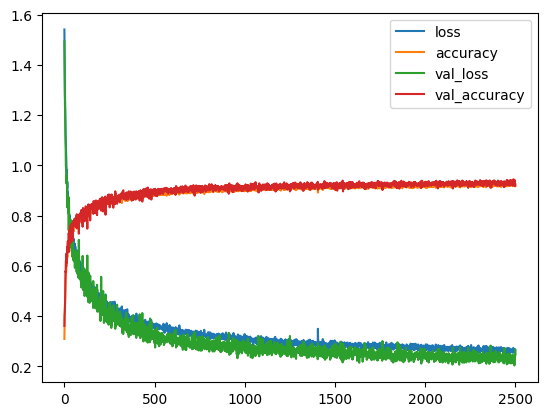

In [18]:
#The funniest of squiggles

pd.DataFrame(hist.history).plot()

In [19]:
model = tf.keras.models.load_model('673KB_model.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '673KB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 20, callbacks = [checkpoint]);

Epoch 1/20
80/80 [==============================] - 6s 59ms/step - loss: 0.2575 - accuracy: 0.9228 - val_loss: 0.2462 - val_accuracy: 0.9240
Epoch 2/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2730 - accuracy: 0.9204 - val_loss: 0.2277 - val_accuracy: 0.9305
Epoch 3/20
80/80 [==============================] - 4s 53ms/step - loss: 0.2646 - accuracy: 0.9214 - val_loss: 0.2305 - val_accuracy: 0.9230
Epoch 4/20
80/80 [==============================] - 4s 53ms/step - loss: 0.2614 - accuracy: 0.9228 - val_loss: 0.2344 - val_accuracy: 0.9260
Epoch 5/20
80/80 [==============================] - 4s 50ms/step - loss: 0.2628 - accuracy: 0.9215 - val_loss: 0.2405 - val_accuracy: 0.9245
Epoch 6/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2648 - accuracy: 0.9218 - val_loss: 0.2533 - val_accuracy: 0.9200
Epoch 7/20
80/80 [==============================] - 4s 51ms/step - loss: 0.2680 - accuracy: 0.9164 - val_loss: 0.2321 - val_accuracy: 0.9355
Epoch 8/20
80

In [ ]:
for i in range(1, 21):
    brute_force(i, '673KB_epochs')

In [ ]:
#Absolute winner, 408KB, but again needs a lot of training

inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same', input_shape=[50, 50, 1])(inp);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.Conv2D(32, kernel_size=(2, 2), activation = 'relu', padding = 'same')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath = '408KB_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 2500, callbacks = [checkpoint]);

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
model = tf.keras.models.load_model('408KB_model.h5');
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '408KB_epochs\{epoch:d}model.h5', monitor = 'val_loss', save_best_only = False, mode = 'min');
hist = model.fit(data_generator.flow(X, y, batch_size = 100, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 10, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/100, epochs = 500, callbacks = [checkpoint]);

In [ ]:
for i in range(1, 501):
    brute_force(i, '408KB_epochs')

In [8]:
s

NameError: name 's' is not defined

In [9]:
ascii

<function ascii(obj, /)>

In [10]:
slice

slice

In [11]:
a

NameError: name 'a' is not defined

In [12]:
s

NameError: name 's' is not defined

In [13]:
ss

NameError: name 'ss' is not defined

In [14]:
s

NameError: name 's' is not defined

In [15]:
s

NameError: name 's' is not defined

In [16]:
s

NameError: name 's' is not defined

In [ ]:
s